In [31]:
# =============================================================
# Cell 1: imports, helpers, validation (same schema as your KKT code)
# =============================================================
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True, linewidth=140)

def ensure_callable(fn, default=0.0):
    """Call user functions uniformly as f(x, y, t) returning a 1D vector."""
    if fn is None:
        return lambda x, y, t: np.full_like(np.asarray(x, float).reshape(-1), default, float)
    
    if isinstance(fn, (int, float)):
        const_val = float(fn)
        return lambda x, y, t: np.full_like(np.asarray(x, float).reshape(-1), const_val, float)
    
    if isinstance(fn, str):
        try:
            # Create safe evaluation context with numpy
            safe_dict = {"np": np, "__builtins__": {}}
            fn = eval(fn, safe_dict)
        except Exception as e:
            print(f"Warning: Could not evaluate string function '{fn}': {e}")
            return lambda x, y, t: np.full_like(np.asarray(x, float).reshape(-1), default, float)

    def _as_1d_like_x(a, n):
        if a is None: return np.zeros(n, float)
        a = np.asarray(a, float)
        if a.size == 1: return np.full(n, float(a), float)
        return a.reshape(-1)

    def wrapper(x, y=None, t=None):
        x = np.asarray(x, float).reshape(-1)
        n = x.shape[0]
        y = _as_1d_like_x(y, n); t = _as_1d_like_x(t, n)
        try: out = fn(x, y, t)
        except TypeError:
            try: out = fn(x, y)
            except TypeError:
                try: out = fn(x)
                except TypeError:
                    out = default
        out = np.asarray(out, float)
        if out.shape == (): return np.full(n, out.item(), float)
        if out.ndim == 1 and out.size == n: return out
        try: return np.broadcast_to(out.reshape(-1), (n,)).astype(float, copy=False)
        except Exception:
            raise ValueError(f"ensure_callable: output shape {out.shape} cannot broadcast to len(x)={n}")
    return wrapper

def is_nonzero(val, tol=0.0): return abs(float(val)) > tol

def _require_keys(d, keys, where=""):
    for k in keys:
        if k not in d: raise ValueError(f"Missing key '{k}' in {where}.")

def validate_problem(problem):
    _require_keys(problem, ["name","dim","time","coeffs","rhs","domain","bc","sampling","model","plot"], "problem")
    dim = problem["dim"]; 
    if dim not in (1,2): raise ValueError("dim must be 1 or 2.")
    time_dep = bool(problem["time"])
    coeffs = problem["coeffs"]
    for k in ["a0","at","att","bx","by","cxx","cxy","cyy"]: coeffs.setdefault(k, 0.0)
    dom = problem["domain"]
    if "x" not in dom or len(dom["x"])!=2: raise ValueError("domain['x'] must be (xl,xr).")
    if dim==2 and ("y" not in dom or len(dom["y"])!=2): raise ValueError("2D needs domain['y']=(yl,yr).")
    if time_dep and ("t" not in dom or len(dom["t"])!=2): raise ValueError("time=True needs domain['t']=(t0,t1).")

    bc = problem["bc"]
    if dim==1 and bc.get("type","").lower()!="periodic":
        for side in ["left","right"]:
            if side not in bc: raise ValueError(f"1D needs bc['{side}'] or bc['type']='periodic'.")
            if "type" not in bc[side] or "value" not in bc[side]: raise ValueError(f"bc['{side}'] needs 'type' and 'value'.")
    if dim==2 and not any(s in bc for s in ("left","right","bottom","top")) and bc.get("type","").lower()!="periodic":
        print("Warning: 2D with no BCs may be underdetermined.")

    samp = problem["sampling"]; _require_keys(samp, ["Nf","Nb","method"], "sampling")
    if samp["Nf"]<=0: raise ValueError("Nf must be >0.")
    if samp["Nb"]<0: raise ValueError("Nb must be >=0.")
    model = problem["model"]; _require_keys(model, ["neurons","activation","seed","ridge"], "model")
    if model["activation"].lower()!="tanh": print("Note: only tanh implemented efficiently; defaulting to tanh.")
    if "weights" not in problem:
        problem["weights"] = {"pde": 1.0, "bc": 10.0, "ic": 5.0}
    else:
        for k, v in {"pde":1.0, "bc":10.0, "ic":5.0}.items(): problem["weights"].setdefault(k, v)

    needs_ic = is_nonzero(coeffs["at"]) or is_nonzero(coeffs["att"])
    has_ic   = ("ic" in problem) and (problem["ic"] is not None)
    if needs_ic and not has_ic: print("Warning: PDE has time derivatives but no IC given.")
    if is_nonzero(coeffs["att"]) and has_ic and "ut" not in (problem["ic"] or {}):
        print("Note: att!=0 → wave-like PDE; consider giving ic['ut'].")


In [4]:
# =============================================================
# Cell 2: sampling (interior + boundary)
# =============================================================
def _van_der_corput(n, base=2):
    vdc, denom = 0.0, 1.0
    while n:
        n, rem = divmod(n, base); denom *= base; vdc += rem/denom
    return vdc

def halton(n, dim, bases=None, start_index=1):
    if bases is None:
        primes=[2,3,5,7,11,13,17,19,23]
        bases=primes[:dim]
    seq=np.empty((n,dim))
    for d in range(dim):
        base=bases[d]
        seq[:,d]=[_van_der_corput(i,base) for i in range(start_index,start_index+n)]
    return seq

def sample_interior(N, domain, dim, method="halton", start_index=1):
    if method=="halton": U=halton(N,dim,start_index=start_index)
    else: U=np.random.rand(N,dim)
    if dim==1:
        xl,xr=domain["x"]; x=xl+(xr-xl)*U[:,0]; return x.reshape(-1,1)
    xl,xr=domain["x"]; yl,yr=domain["y"]
    x=xl+(xr-xl)*U[:,0]; y=yl+(yr-yl)*U[:,1]
    return np.stack([x,y],axis=1)

def sample_boundary(Nb, domain, dim, method="halton", start_index=10001):
    sides={}
    if dim==1:
        xl,xr=domain["x"]; sides["left"]=np.array([[xl]]); sides["right"]=np.array([[xr]]); return sides
    xl,xr=domain["x"]; yl,yr=domain["y"]; k=max(1,Nb//4)
    t=halton(k,1,start_index=start_index).ravel() if method=="halton" else np.random.rand(k)
    sides["left"]=np.stack([np.full_like(t,xl), yl+(yr-yl)*t],axis=1)
    sides["right"]=np.stack([np.full_like(t,xr), yl+(yr-yl)*(1-t)],axis=1)
    sides["bottom"]=np.stack([xl+(xr-xl)*t, np.full_like(t,yl)],axis=1)
    sides["top"]=np.stack([xl+(xr-xl)*(1-t), np.full_like(t,yr)],axis=1)
    return sides


In [5]:
# =============================================================
# Cell 3: random tanh features & derivatives
# =============================================================
def init_features(neurons, dim, time, seed=42):
    rng=np.random.default_rng(seed)
    Wx=rng.normal(size=neurons) if dim>=1 else np.zeros(neurons)
    Wy=rng.normal(size=neurons) if dim==2 else np.zeros(neurons)
    Wt=rng.normal(size=neurons) if time else np.zeros(neurons)
    b =rng.normal(size=neurons)
    return {"Wx":Wx,"Wy":Wy,"Wt":Wt,"b":b,"neurons":neurons,"dim":dim,"time":bool(time)}

def _z(feat, X, T):
    Wx,Wy,Wt,b=feat["Wx"],feat["Wy"],feat["Wt"],feat["b"]
    n = X.shape[0]
    z=np.outer(X[:,0],Wx)+b
    if feat["dim"]==2: z+=np.outer(X[:,1],Wy)
    if feat["time"] and T is not None:
        T = np.asarray(T, float).ravel()
        if T.size == 1: T = np.full(n, T.item(), float)
        elif T.size != n: T = np.resize(T, n).astype(float, copy=False)
        z+=np.outer(T,Wt)
    return z

def _tanh(z): return np.tanh(z)
def _sech2(z): return (1/np.cosh(z))**2

def phi(feat,X,T=None):   return _tanh(_z(feat,X,T))
def phi_x(feat,X,T=None): return _sech2(_z(feat,X,T))*feat["Wx"]
def phi_y(feat,X,T=None): 
    return np.zeros((X.shape[0],feat["neurons"])) if feat["dim"]!=2 else _sech2(_z(feat,X,T))*feat["Wy"]
def phi_t(feat,X,T=None):
    return np.zeros((X.shape[0],feat["neurons"])) if not feat["time"] else _sech2(_z(feat,X,T))*feat["Wt"]

def phi_xx(feat,X,T=None):
    z=_z(feat,X,T); return (-2*_tanh(z)*_sech2(z))*(feat["Wx"]**2)
def phi_yy(feat,X,T=None):
    if feat["dim"]!=2: return np.zeros((X.shape[0],feat["neurons"]))
    z=_z(feat,X,T); return (-2*_tanh(z)*_sech2(z))*(feat["Wy"]**2)
def phi_xy(feat,X,T=None):
    if feat["dim"]!=2: return np.zeros((X.shape[0],feat["neurons"]))
    z=_z(feat,X,T); return (-2*_tanh(z)*_sech2(z))*(feat["Wx"]*feat["Wy"])
def phi_tt(feat,X,T=None):
    if not feat["time"]: return np.zeros((X.shape[0],feat["neurons"]))
    z=_z(feat,X,T); return (-2*_tanh(z)*_sech2(z))*(feat["Wt"]**2)


In [6]:
# =============================================================
# Cell 4: assemble weighted LS system (no KKT) for the "mother equation"
#           a0 u + at u_t + att u_tt + bx u_x + by u_y + cxx u_xx + cxy u_xy + cyy u_yy = rhs
# All diffusion is in the +nu convention; pass negative nu to represent "−Δ".
# Periodic(1D) enforces u(0,t)=u(1,t) and u_x(0,t)=u_x(1,t) softly at many t.
# =============================================================
def boundary_normal(side,dim):
    if dim==1: return -1.0 if side=="left" else +1.0
    if side=="left": return np.array([-1,0])
    if side=="right": return np.array([1,0])
    if side=="bottom": return np.array([0,-1])
    if side=="top": return np.array([0,1])
    raise ValueError(f"unknown side {side}")

def neumann_rows(feat,side,P,T,dim):
    Px=phi_x(feat,P,T)
    if dim==1: return boundary_normal(side,1)*Px
    Py=phi_y(feat,P,T); n=boundary_normal(side,2)
    return n[0]*Px+n[1]*Py

def assemble_system_soft(problem, feat):
    dim        = int(problem.get("dim", 1))
    time_dep   = bool(problem.get("time", False))
    coeffs     = problem.get("coeffs", {})
    rhs_fun    = ensure_callable(problem.get("rhs", 0.0), 0.0)
    dom        = problem.get("domain", {"x": (0.0,1.0)})
    bc         = problem.get("bc", {})
    ic_block   = problem.get("ic", None)
    samp       = problem.get("sampling", {})
    w          = problem.get("weights", {"pde":1.0, "bc":10.0, "ic":5.0})

    # sampling
    Nf   = int(samp.get("Nf", 400))
    Nb   = int(samp.get("Nb", 40))
    Ni   = int(samp.get("Ni", max(1, Nf//3))) if time_dep else 0
    meth = samp.get("method", "halton")
    Nt_slices = int(samp.get("Nt_slices", 64)) if time_dep else 0

    # coeffs
    a0  = float(coeffs.get("a0", 0.0))
    at  = float(coeffs.get("at", 0.0))
    att = float(coeffs.get("att", 0.0))
    bx  = float(coeffs.get("bx", 0.0))
    by  = float(coeffs.get("by", 0.0))
    cxx = float(coeffs.get("cxx", 0.0))
    cxy = float(coeffs.get("cxy", 0.0))
    cyy = float(coeffs.get("cyy", 0.0))

    # Interior points
    X = sample_interior(Nf, dom, dim, meth)
    if time_dep:
        t0, t1 = dom.get("t", (0.0, 1.0))
        T = t0 + (t1 - t0) * np.random.rand(X.shape[0])
    else:
        T = None
    zero_t = np.zeros(X.shape[0])

    # PDE rows
    Phi = phi(feat, X, T)
    Hp  = np.zeros((X.shape[0], feat["neurons"]))
    if is_nonzero(a0):  Hp += a0  * Phi
    if is_nonzero(at):  Hp += at  * phi_t(feat, X, T)
    if is_nonzero(att): Hp += att * phi_tt(feat, X, T)
    if is_nonzero(bx):  Hp += bx  * phi_x(feat, X, T)
    if dim==2 and is_nonzero(by):  Hp += by * phi_y(feat, X, T)
    if is_nonzero(cxx): Hp += cxx * phi_xx(feat, X, T)
    if dim==2 and is_nonzero(cyy): Hp += cyy * phi_yy(feat, X, T)
    if dim==2 and is_nonzero(cxy): Hp += cxy * phi_xy(feat, X, T)
    Kp  = rhs_fun(X[:,0], X[:,1] if dim==2 else np.zeros_like(X[:,0]), T if T is not None else zero_t)

    H_list = [Hp * w["pde"]]
    K_list = [np.asarray(Kp).reshape(-1,1) * w["pde"]]

    # BC rows (soft)
    sides = sample_boundary(Nb, dom, dim, meth)
    bc_type = (bc.get("type","").lower() if isinstance(bc, dict) else "").strip()

    if dim==1 and bc_type == "periodic":
        xL, xR = dom["x"]
        if time_dep:
            t0, t1 = dom.get("t", (0.0,1.0))
            tgrid = np.linspace(t0, t1, max(16, Nt_slices)).reshape(-1)
        else:
            tgrid = np.array([0.0])
        x0 = np.full((tgrid.shape[0],1), xL)
        x1 = np.full((tgrid.shape[0],1), xR)
        Tbc= tgrid.reshape(-1,1) if time_dep else None

        H0 = phi(feat, x0, Tbc); H1 = phi(feat, x1, Tbc)
        H_list.append((H0 - H1) * w["bc"]); K_list.append(np.zeros((H0.shape[0],1)))
        H0x = phi_x(feat, x0, Tbc); H1x = phi_x(feat, x1, Tbc)
        H_list.append((H0x - H1x) * w["bc"]); K_list.append(np.zeros((H0x.shape[0],1)))
    else:
        for side, P in sides.items():
            if side not in bc or bc[side] is None: continue
            bctype = bc[side]["type"].lower()
            gfun   = ensure_callable(bc[side]["value"], 0.0)
            Tb = None; zeros = np.zeros(P.shape[0])
            if time_dep:
                t0, t1 = dom.get("t",(0.0,1.0))
                Tb = t0 + (t1 - t0) * np.random.rand(P.shape[0])

            xvals = P[:,0]; yvals = P[:,1] if dim==2 else np.zeros_like(P[:,0]); tvals = Tb if Tb is not None else zeros

            if bctype == "dirichlet":
                Hb = phi(feat, P, Tb)
                Gb = gfun(xvals, yvals, tvals).reshape(-1,1)
                H_list.append(Hb * w["bc"]); K_list.append(Gb * w["bc"])
            elif bctype == "neumann":
                Hb = neumann_rows(feat, side, P, Tb, dim)
                Gb = gfun(xvals, yvals, tvals).reshape(-1,1)
                H_list.append(Hb * w["bc"]); K_list.append(Gb * w["bc"])

    # IC rows (soft)
    if time_dep and ic_block is not None:
        Ni = int(samp.get("Ni", max(1, Nf//3)))
        Pi = sample_interior(Ni, dom, dim, meth)
        t0 = dom.get("t",(0.0,1.0))[0]; Ti = np.full(Pi.shape[0], t0)
        zeros = np.zeros(Pi.shape[0])
        if "u" in ic_block and ic_block["u"] is not None:
            Hi = phi(feat, Pi, Ti)
            Ui = ensure_callable(ic_block["u"])(Pi[:,0], Pi[:,1] if dim==2 else np.zeros_like(Pi[:,0]), zeros).reshape(-1,1)
            H_list.append(Hi * w["ic"]); K_list.append(Ui * w["ic"])
        if is_nonzero(coeffs.get("att",0.0)) and "ut" in ic_block and ic_block["ut"] is not None:
            Hit = phi_t(feat, Pi, Ti)
            Ut  = ensure_callable(ic_block["ut"])(Pi[:,0], Pi[:,1] if dim==2 else np.zeros_like(Pi[:,0]), zeros).reshape(-1,1)
            H_list.append(Hit * w["ic"]); K_list.append(Ut * w["ic"])

    H = np.vstack(H_list) if H_list else np.zeros((0, feat["neurons"]))
    K = np.vstack(K_list) if K_list else np.zeros((0,1))
    return H, K


In [7]:
# =============================================================
# Cell 5: PIELM solve (single least-squares with a bias column) + plotting
# =============================================================
def solve_problem(problem):
    validate_problem(problem)
    dim = problem["dim"]; time_dep = bool(problem["time"]); model = problem["model"]
    ridge = float(model.get("ridge", 0.0))

    # features and system
    feat = init_features(model["neurons"], dim, time_dep, seed=model["seed"])
    H, K = assemble_system_soft(problem, feat)

    # add output bias column and solve LS (pseudo-inverse / ridge)
    ones = np.ones((H.shape[0], 1))
    Hs   = np.hstack([H, ones])
    if ridge and ridge > 0:
        A = Hs.T @ Hs + ridge * np.eye(Hs.shape[1]); b = Hs.T @ K
        try: c = np.linalg.solve(A, b)
        except np.linalg.LinAlgError: c, *_ = np.linalg.lstsq(A, b, rcond=None)
    else:
        c = np.linalg.pinv(Hs) @ K
    c = c.reshape(-1,1)
    c_feat, c_bias = c[:-1], c[-1]

    # predictor
    def predict_u(x, y=None, t=None):
        x = np.asarray(x).reshape(-1)
        if dim == 2:
            if y is None: raise ValueError("2D requires y.")
            y = np.asarray(y).reshape(-1)
            if y.shape[0] != x.shape[0]: raise ValueError("x,y lengths must match.")
            X = np.stack([x, y], axis=1)
        else:
            X = x[:, None]
        if time_dep:
            if t is None: raise ValueError("time-dependent problem requires 't'.")
            t = np.asarray(t).reshape(-1)
            if t.size == 1: T = np.full(X.shape[0], t.item())
            elif t.size == X.shape[0]: T = t
            else: T = np.resize(t, X.shape[0])
        else:
            T = None
        return (phi(feat, X, T) @ c_feat).ravel() + float(c_bias)

    # ---------- plotting ----------
    exact = problem["plot"].get("exact", None)
    exact_fn = ensure_callable(exact) if exact is not None else None
    title = problem["name"]
    want_surface3d = bool(problem["plot"].get("surface3d", False))

    if dim == 1 and not time_dep:
        xL, xR = problem["domain"]["x"]; npl = problem["plot"].get("n_plot", 600)
        x = np.linspace(xL, xR, npl)
        up = predict_u(x)
        plt.figure(figsize=(10,3.3), constrained_layout=True)
        ax1 = plt.subplot(1,2,1)
        if exact_fn is not None:
            ue = exact_fn(x, None, 0.0); ax1.plot(x, ue, 'b', lw=1.8, label='Exact')
        ax1.plot(x, up, 'r--', lw=1.8, label='PIELM'); ax1.set_title(title.split(':')[0])
        ax1.set_xlabel('x'); ax1.set_ylabel('u'); ax1.grid(alpha=.3); ax1.legend(loc='upper left')
        ax2 = plt.subplot(1,2,2)
        if exact_fn is not None:
            ax2.plot(x, up-ue, 'r', lw=1.5); ax2.axhline(0, color='k', ls='--', lw=.8)
            ax2.set_title('Point-wise error'); ax2.set_xlabel('x'); ax2.set_ylabel('error'); ax2.grid(alpha=.3)
        plt.show()

    elif dim == 1 and time_dep:
        xL, xR = problem["domain"]["x"]; npl = problem["plot"].get("n_plot", 600)
        times = problem["plot"].get("times", None)
        if times is None:
            t0, t1 = problem["domain"]["t"]; times = np.linspace(t0, t1, 5)
        x = np.linspace(xL, xR, npl)

        fig, axs = plt.subplots(1, len(times), figsize=(2.0*len(times),3.1), constrained_layout=True)
        if len(times)==1: axs=[axs]
        for j,tv in enumerate(times):
            up = predict_u(x, t=np.full(x.size, tv))
            if exact_fn is not None:
                ue = exact_fn(x, None, np.full(x.size, tv))
                axs[j].plot(x, ue, 'b', lw=1.8, label='Exact' if j==0 else "")
            axs[j].plot(x, up, 'r--', lw=1.8, label='PIELM' if j==0 else "")
            axs[j].set_title(f'{title.split(":")[0]}  t={tv:g}'); axs[j].set_xlabel('x')
            if j==0: axs[j].set_ylabel('u'); axs[j].grid(alpha=.3)
        if exact_fn is not None: axs[0].legend(loc='upper left'); plt.show()

        if exact_fn is not None:
            fig, axs = plt.subplots(1, len(times), figsize=(2.0*len(times),3.1), constrained_layout=True)
            if len(times)==1: axs=[axs]
            for j,tv in enumerate(times):
                up = predict_u(x, t=np.full(x.size, tv)); ue = exact_fn(x, None, np.full(x.size, tv))
                axs[j].plot(x, up-ue, 'r', lw=1.5); axs[j].axhline(0, color='k', ls='--', lw=.8)
                axs[j].set_title(f'error  t={tv:g}'); axs[j].set_xlabel('x')
                if j==0: axs[j].set_ylabel('error'); axs[j].grid(alpha=.3)
            plt.show()

    else:
        xL,xR=problem["domain"]["x"]; yL,yR=problem["domain"]["y"]; npl=problem["plot"].get("n_plot", 140)
        xs, ys = np.linspace(xL,xR,npl), np.linspace(yL,yR,npl); xx, yy = np.meshgrid(xs, ys)

        if not time_dep:
            P = np.c_[xx.ravel(), yy.ravel()]
            up = predict_u(P[:,0], P[:,1]).reshape(npl, npl)
            fig, axs = plt.subplots(1,2, figsize=(10,3.6), constrained_layout=True, sharex=True, sharey=True)
            m0 = axs[0].contourf(xx, yy, up, 50, cmap='jet'); axs[0].set_title(title+' – PIELM'); plt.colorbar(m0, ax=axs[0], fraction=.046)
            if exact_fn is not None:
                ue = exact_fn(P[:,0], P[:,1], np.zeros(P.shape[0])).reshape(npl, npl)
                err = up - ue
                m1 = axs[1].contourf(xx, yy, err, 50, cmap='jet'); axs[1].set_title('Point-wise error'); plt.colorbar(m1, ax=axs[1], fraction=.046)
            else:
                axs[1].axis('off')
            for a in axs: a.set_xlabel('x'); a.set_ylabel('y')
            plt.show()

            if want_surface3d:
                from mpl_toolkits.mplot3d import Axes3D  # noqa
                fig = plt.figure(figsize=(15,5))
                ax1 = fig.add_subplot(131, projection='3d'); s1 = ax1.plot_surface(xx, yy, up, cmap='viridis', linewidth=0, antialiased=True)
                ax1.set_title('PIELM'); ax1.set_xlabel('x'); ax1.set_ylabel('y'); ax1.set_zlabel('u'); fig.colorbar(s1, ax=ax1, shrink=0.6)
                if exact_fn is not None:
                    ax2 = fig.add_subplot(132, projection='3d'); s2 = ax2.plot_surface(xx, yy, ue, cmap='viridis', linewidth=0, antialiased=True)
                    ax2.set_title('Exact'); ax2.set_xlabel('x'); ax2.set_ylabel('y'); ax2.set_zlabel('u'); fig.colorbar(s2, ax=ax2, shrink=0.6)
                    ax3 = fig.add_subplot(133, projection='3d'); s3 = ax3.plot_surface(xx, yy, err, cmap='coolwarm', linewidth=0, antialiased=True)
                    ax3.set_title('Error'); ax3.set_xlabel('x'); ax3.set_ylabel('y'); ax3.set_zlabel('error'); fig.colorbar(s3, ax=ax3, shrink=0.6)
                plt.tight_layout(); plt.show()

        else:
            times = problem["plot"].get("times", None)
            if times is None:
                t0, t1 = problem["domain"]["t"]; times = np.linspace(t0, t1, 4)
            fig, axs = plt.subplots(1, len(times), figsize=(3.2*len(times),3.6), constrained_layout=True, sharex=True, sharey=True)
            if len(times)==1: axs=[axs]
            last_m = None
            for ax, tv in zip(axs, times):
                P = np.c_[xx.ravel(), yy.ravel()]
                up = predict_u(P[:,0], P[:,1], t=np.full(P.shape[0], tv)).reshape(npl, npl)
                m = ax.contourf(xx, yy, up, 50, cmap='jet'); last_m = m
                ax.set(title=f'{title.split(":")[0]}  t={tv:g}', xlabel='x', ylabel='y')
            if last_m is not None: fig.colorbar(last_m, ax=axs, shrink=0.85, label='u'); plt.show()

            if exact_fn is not None:
                fig, axs = plt.subplots(1, len(times), figsize=(3.2*len(times),3.6), constrained_layout=True, sharex=True, sharey=True)
                if len(times)==1: axs=[axs]
                last_m = None
                for ax, tv in zip(axs, times):
                    P  = np.c_[xx.ravel(), yy.ravel()]
                    up = predict_u(P[:,0], P[:,1], t=np.full(P.shape[0], tv)).reshape(npl, npl)
                    ue = exact_fn(P[:,0], P[:,1], np.full(P.shape[0], tv)).reshape(npl, npl)
                    err = up - ue
                    m = ax.contourf(xx, yy, err, 50, cmap='jet'); last_m = m
                    ax.set(title=f'Error  t={tv:g}', xlabel='x', ylabel='y')
                if last_m is not None: fig.colorbar(last_m, ax=axs, shrink=0.85, label='error'); plt.show()

    info = {"H_rows": H.shape[0], "neurons": model["neurons"], "ridge": ridge, "dim": dim, "time": time_dep}
    return predict_u, info


C:\Users\sudha\AppData\Local\Temp\ipykernel_13760\567331620.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if a.size == 1: return np.full(n, float(a), float)
C:\Users\sudha\AppData\Local\Temp\ipykernel_13760\1991114609.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return (phi(feat, X, T) @ c_feat).ravel() + float(c_bias)


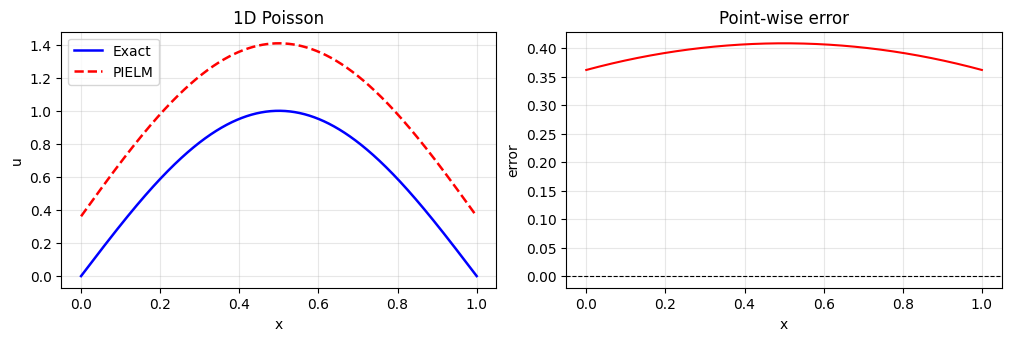

Info A: {'H_rows': 902, 'neurons': 980, 'ridge': 1e-08, 'dim': 1, 'time': False}


In [8]:
# =============================================================
# Cell 6: Example A — 1D Poisson mother equation (Dirichlet 0,0)
# =============================================================
pi = np.pi
problem_A = {
    "name": "1D Poisson: u_xx = -pi^2 sin(pi x)",
    "dim": 1, "time": False,
    "coeffs": {"a0":0,"at":0,"att":0,"bx":0,"by":0,"cxx":1.0,"cxy":0,"cyy":0},
    "rhs": lambda x,y,t: - (pi**2) * np.sin(pi*x),
    "domain": {"x": (0.0, 1.0)},
    "bc": {
        "left":  {"type":"dirichlet", "value": lambda x,y,t: 0.0},
        "right": {"type":"dirichlet", "value": lambda x,y,t: 0.0},
    },
    "sampling": {"Nf": 900, "Nb": 20, "method":"halton"},
    "model":    {"neurons": 980, "activation":"tanh", "seed": 42, "ridge": 1e-8},
    "weights":  {"pde": 1.0, "bc": 30.0, "ic": 5.0},
    "plot":     {"exact": lambda x,y,t: np.sin(pi*x), "n_plot": 900}
}
predict_u_A, info_A = solve_problem(problem_A); print("Info A:", info_A)


Running TC-1 …


C:\Users\sudha\AppData\Local\Temp\ipykernel_13760\567331620.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if a.size == 1: return np.full(n, float(a), float)
C:\Users\sudha\AppData\Local\Temp\ipykernel_13760\1991114609.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return (phi(feat, X, T) @ c_feat).ravel() + float(c_bias)


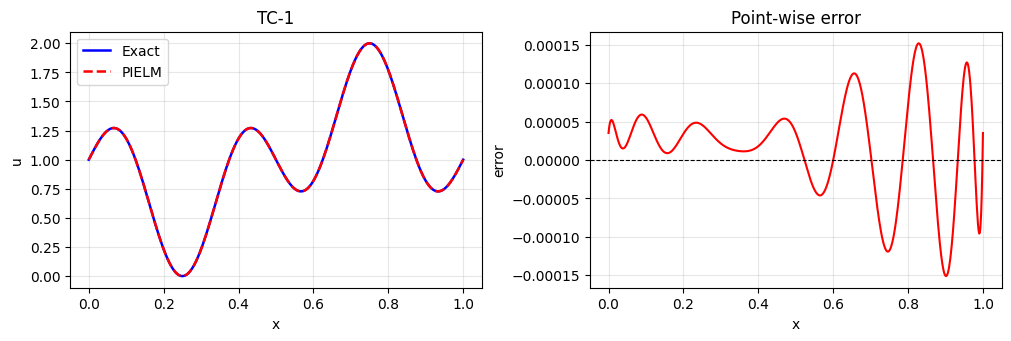

Running TC-2 …


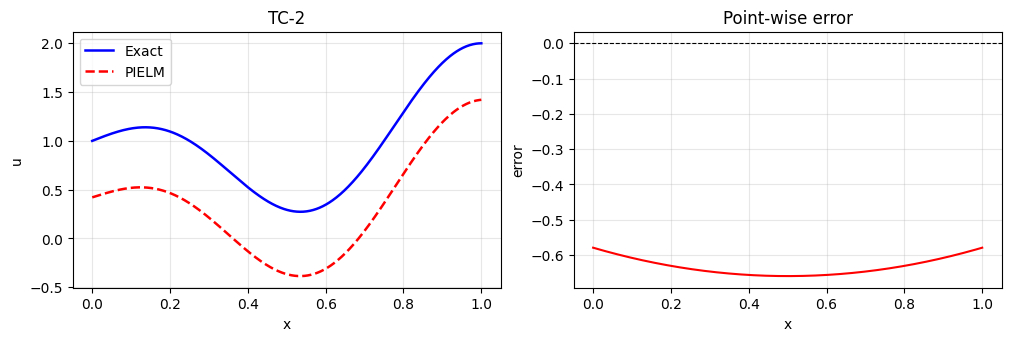

Running TC-3 …


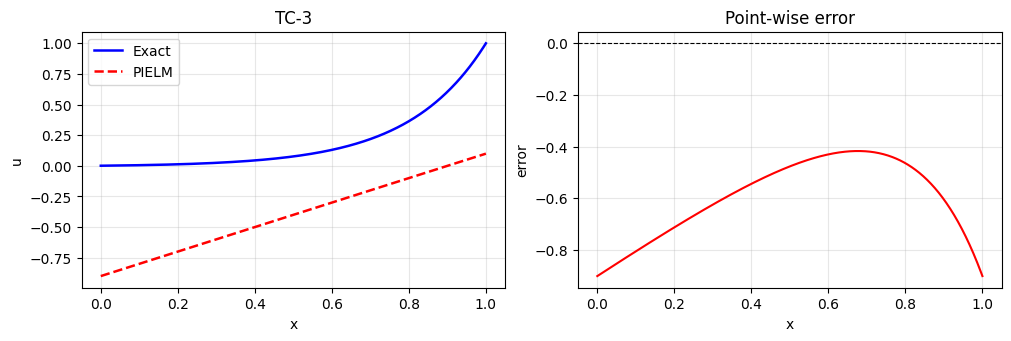

Running TC-4 …


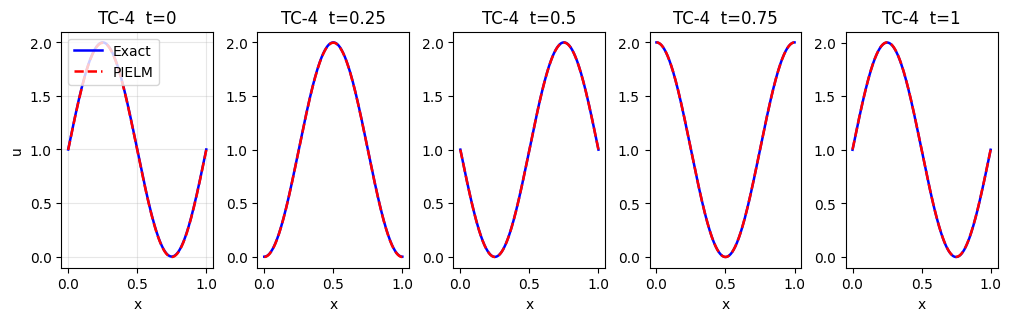

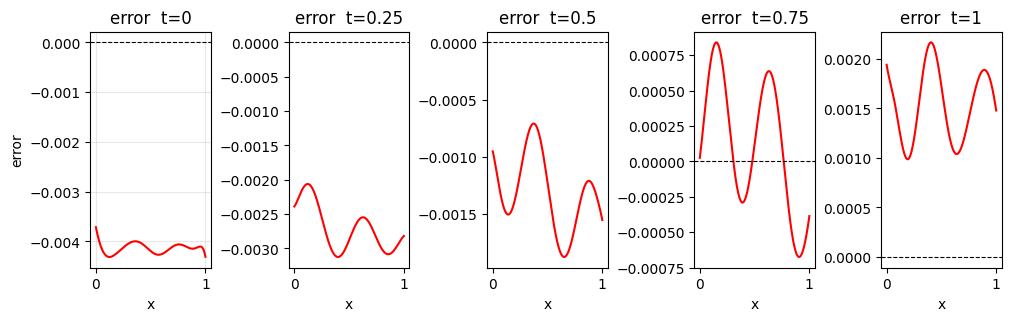

Running TC-5 …


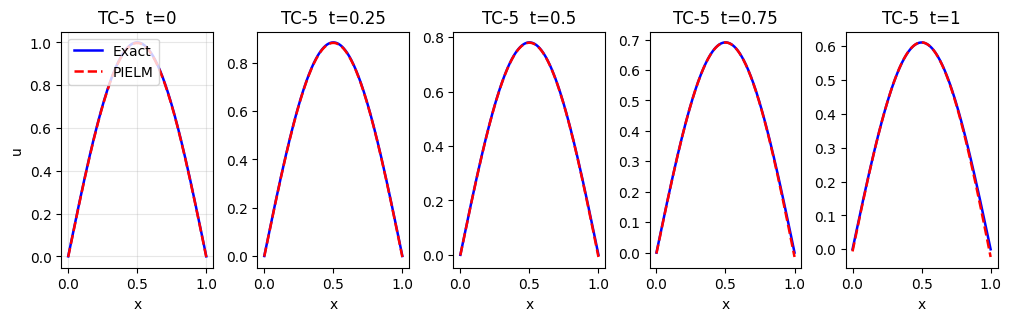

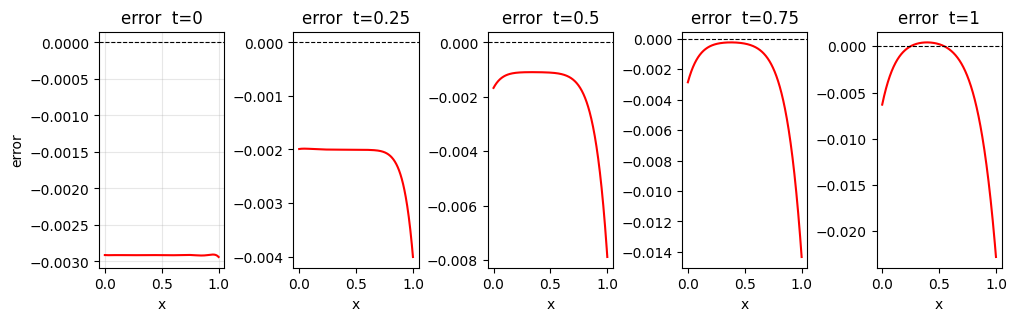

Running TC-6 …


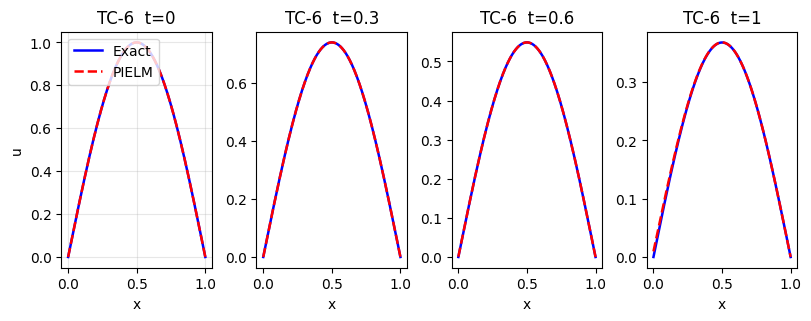

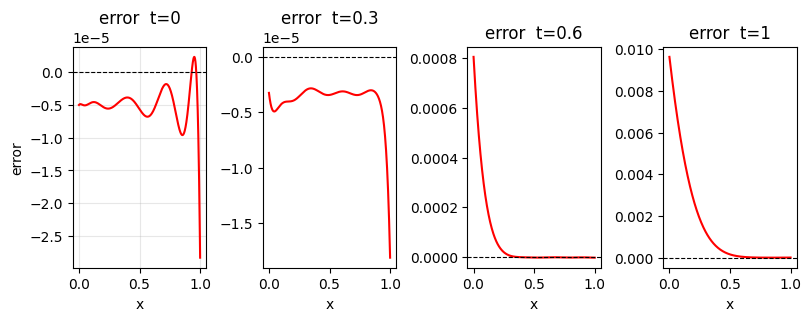

Running TC-7 …


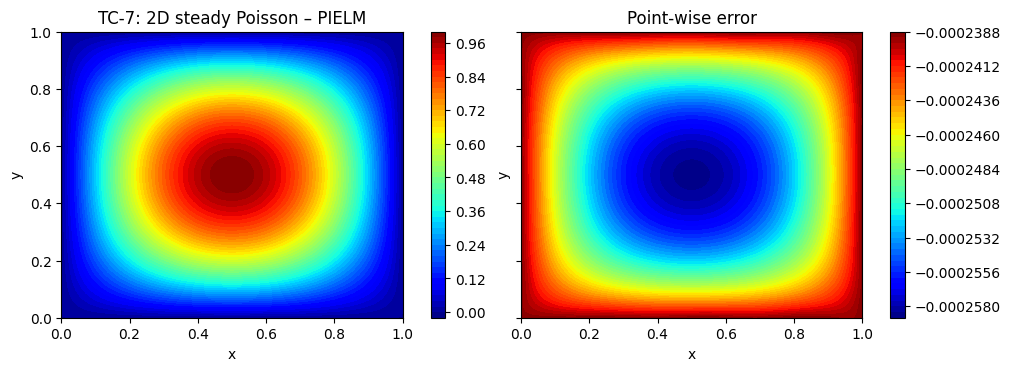

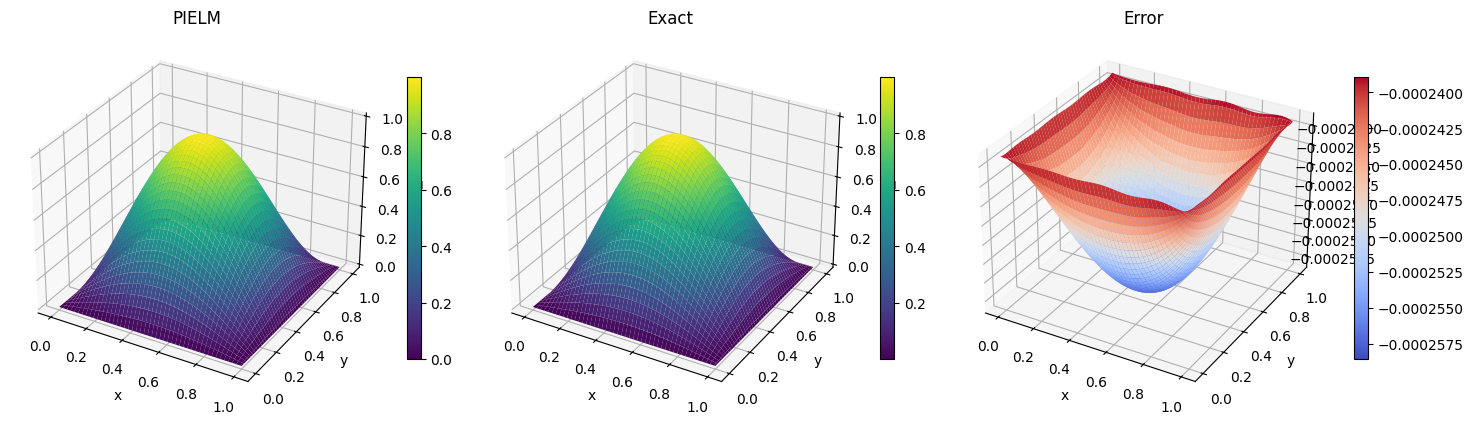

Running TC-8 …


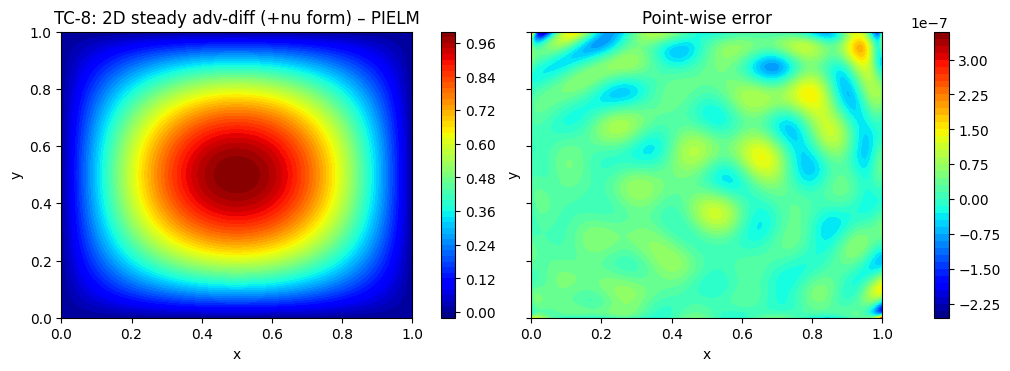

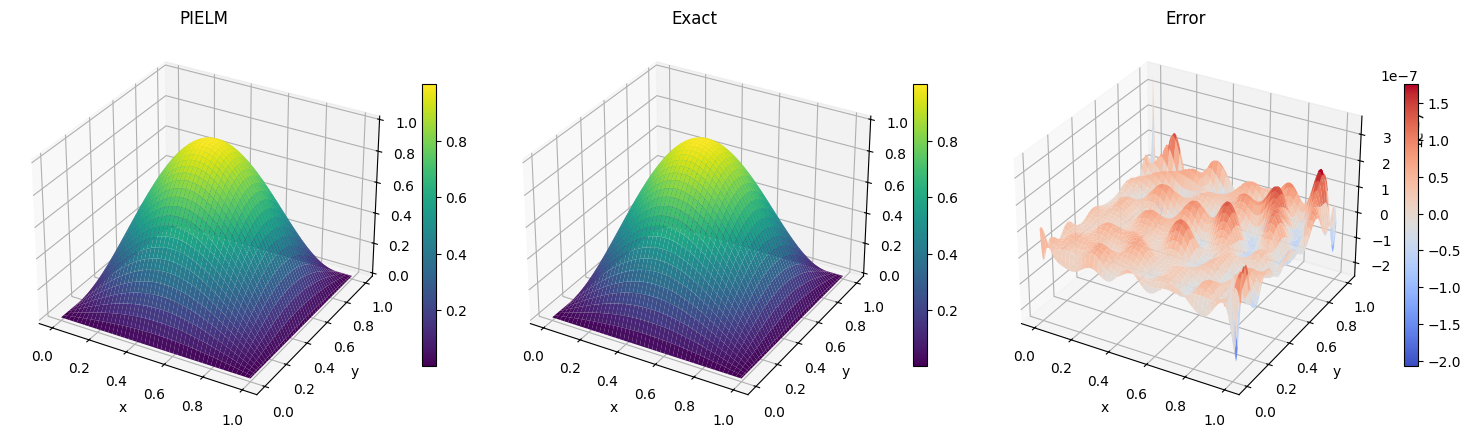

Running TC-9 …


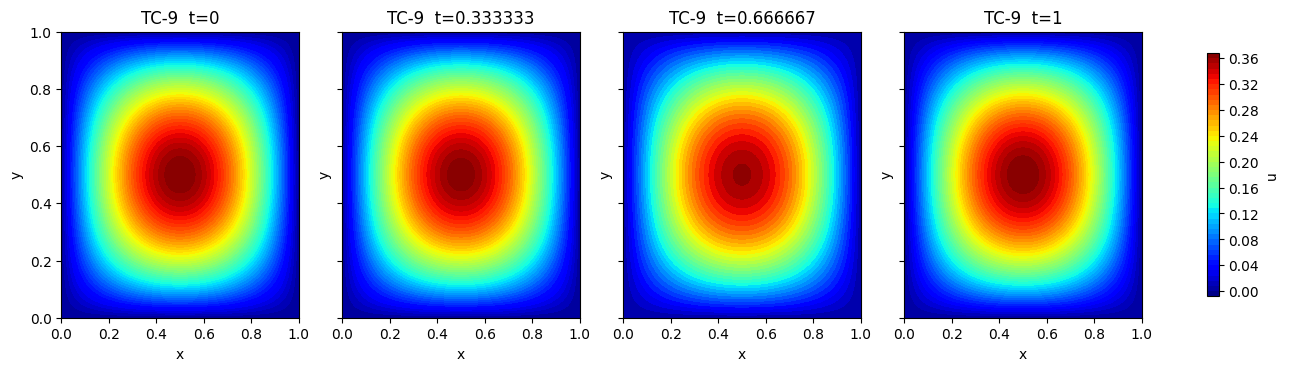

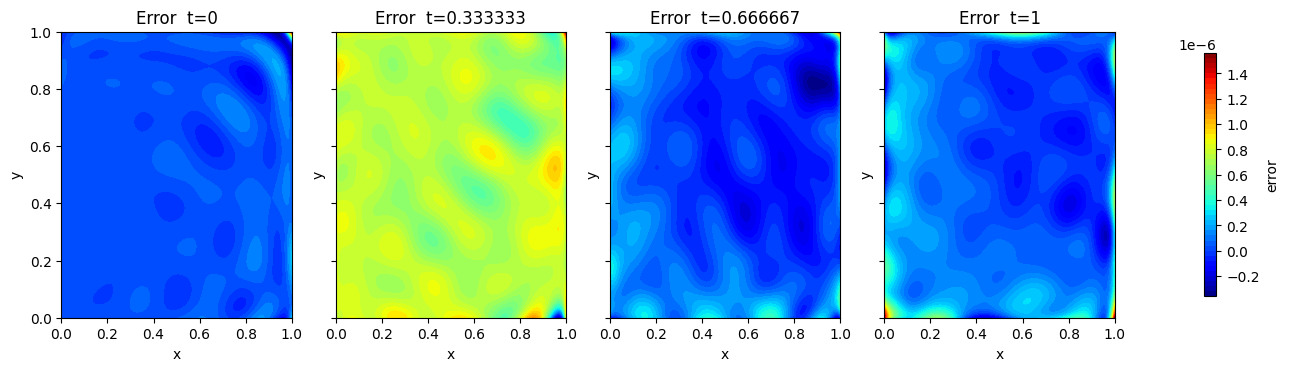

(<function __main__.solve_problem.<locals>.predict_u(x, y=None, t=None)>,
 {'H_rows': 13600, 'neurons': 7000, 'ridge': 1e-08, 'dim': 2, 'time': True})

In [11]:
# =============================================================
# Cell 7: Test cases TC-1 … TC-9 using the PIELM solver above
# =============================================================
def run_TC1():
    u_exact = lambda x,y,t: np.sin(2*np.pi*x) * np.cos(4*np.pi*x) + 1.0
    rhs = lambda x,y,t: 2*np.pi*np.cos(2*np.pi*x)*np.cos(4*np.pi*x) - 4*np.pi*np.sin(2*np.pi*x)*np.sin(4*np.pi*x)
    xL, xR = 0.0, 1.0; gL = float(u_exact(xL,0,0)); gR = float(u_exact(xR,0,0))
    prob = {
        "name":"TC-1: 1D steady advection","dim":1,"time":False,
        "coeffs":{"a0":0,"at":0,"att":0,"bx":1.0,"by":0,"cxx":0,"cxy":0,"cyy":0},
        "rhs": rhs, "domain":{"x":(xL,xR)},
        "bc":{"left":{"type":"dirichlet","value":lambda x,y,t:gL},
              "right":{"type":"dirichlet","value":lambda x,y,t:gR}},
        "sampling":{"Nf":1000,"Nb":2,"method":"halton"},
        "model":{"neurons":800,"activation":"tanh","seed":1,"ridge":1e-10},
        "weights":{"pde":1.0,"bc":10.0,"ic":5.0},
        "plot":{"exact":u_exact,"n_plot":600}
    }
    return solve_problem(prob)

def run_TC2():
    u_exact = lambda x,y,t: np.sin(0.5*np.pi*x) * np.cos(2*np.pi*x) + 1.0
    rhs = lambda x,y,t: - (17.0/4.0)*(np.pi**2)*np.sin(0.5*np.pi*x)*np.cos(2*np.pi*x) - 2.0*(np.pi**2)*np.cos(0.5*np.pi*x)*np.sin(2*np.pi*x)
    xL,xR=0.0,1.0; gL=float(u_exact(xL,0,0)); gR=float(u_exact(xR,0,0))
    prob = {
        "name":"TC-2: 1D steady Poisson","dim":1,"time":False,
        "coeffs":{"a0":0,"at":0,"att":0,"bx":0,"by":0,"cxx":1.0,"cxy":0,"cyy":0},
        "rhs":rhs,"domain":{"x":(xL,xR)},
        "bc":{"left":{"type":"dirichlet","value":lambda x,y,t:gL},
              "right":{"type":"dirichlet","value":lambda x,y,t:gR}},
        "sampling":{"Nf":1000,"Nb":2,"method":"halton"},
        "model":{"neurons":900,"activation":"tanh","seed":2,"ridge":1e-10},
        "plot":{"exact":u_exact,"n_plot":600}
    }
    return solve_problem(prob)

def run_TC3(nu=-0.20):
    u_exact = lambda x,y,t: (np.exp(x/(-nu)) - 1.0) / (np.exp(1.0/(-nu)) - 1.0)
    rhs = lambda x,y,t: np.zeros_like(x); xL,xR=0.0,1.0
    prob = {
        "name":"TC-3: 1D steady adv-diff","dim":1,"time":False,
        "coeffs":{"a0":0,"at":0,"att":0,"bx":1.0,"by":0,"cxx":float(nu),"cxy":0,"cyy":0},
        "rhs":rhs,"domain":{"x":(xL,xR)},
        "bc":{"left":{"type":"dirichlet","value":lambda x,y,t:0.0},
              "right":{"type":"dirichlet","value":lambda x,y,t:1.0}},
        "sampling":{"Nf":1000,"Nb":2,"method":"halton"},
        "model":{"neurons":800,"activation":"tanh","seed":3,"ridge":1e-10},
        "plot":{"exact":u_exact,"n_plot":600}
    }
    return solve_problem(prob)

def run_TC4():
    a=1.0
    u_exact=lambda x,y,t: 1.0 + np.sin(2*np.pi*(x - t)); rhs=lambda x,y,t: np.zeros_like(x)
    xL,xR=0.0,1.0
    prob={
        "name":"TC-4: 1D unsteady advection","dim":1,"time":True,
        "coeffs":{"a0":0,"at":1.0,"att":0,"bx":a,"by":0,"cxx":0,"cxy":0,"cyy":0},
        "rhs":rhs,"domain":{"x":(xL,xR),"t":(0.0,1.0)},
        "bc":{"type":"periodic"},
        "ic":{"u": lambda x,y,t: u_exact(x,y,0.0)},
        "sampling":{"Nf":2400,"Nb":400,"Ni":400,"Nt_slices":24,"method":"halton"},
        "model":{"neurons":1800,"activation":"tanh","seed":7,"ridge":1e-6},
        "plot":{"exact":u_exact,"n_plot":600,"times":[0.0,0.25,0.5,0.75,1.0]}
    }
    return solve_problem(prob)

def run_TC5():
    nu=-0.05
    u_exact=lambda x,y,t: np.sin(np.pi*x)*np.exp(-(abs(nu))*(np.pi**2)*t); rhs=lambda x,y,t: np.zeros_like(x)
    xL,xR=0.0,1.0
    prob={
        "name":"TC-5: 1D unsteady diffusion","dim":1,"time":True,
        "coeffs":{"a0":0,"at":1.0,"att":0,"bx":0,"by":0,"cxx":nu,"cxy":0,"cyy":0},
        "rhs":rhs,"domain":{"x":(xL,xR),"t":(0.0,1.0)},
        "bc":{"left":{"type":"dirichlet","value":lambda x,y,t:0.0},
              "right":{"type":"dirichlet","value":lambda x,y,t:0.0}},
        "ic":{"u": lambda x,y,t: u_exact(x,y,0.0)},
        "sampling":{"Nf":2400,"Nb":160,"Ni":400,"Nt_slices":24,"method":"halton"},
        "model":{"neurons":1800,"activation":"tanh","seed":8,"ridge":1e-6},
        "plot":{"exact":u_exact,"n_plot":600,"times":[0.0,0.25,0.5,0.75,1.0]}
    }
    return solve_problem(prob)

def run_TC6():
    a,nu=0.7,-0.02
    def u_exact(x,y,t): return np.sin(np.pi*x)*np.exp(-t)
    def rhs(x,y,t):
        x=np.asarray(x); ut=-np.sin(np.pi*x)*np.exp(-t); ux=np.pi*np.cos(np.pi*x)*np.exp(-t); uxx=-(np.pi**2)*np.sin(np.pi*x)*np.exp(-t)
        return ut + a*ux + nu*uxx
    xL,xR=0.0,1.0
    prob={
        "name":"TC-6: 1D unsteady advection–diffusion","dim":1,"time":True,
        "coeffs":{"a0":0,"at":1.0,"att":0,"bx":a,"by":0,"cxx":nu,"cxy":0,"cyy":0},
        "rhs":rhs,"domain":{"x":(xL,xR),"t":(0.0,1.0)},
        "bc":{"left":{"type":"dirichlet","value":lambda x,y,t:0.0},
              "right":{"type":"dirichlet","value":lambda x,y,t:0.0}},
        "ic":{"u": lambda x,y,t: u_exact(x,y,0.0)},
        "sampling":{"Nf":3000,"Nb":200,"Ni":500,"Nt_slices":28,"method":"halton"},
        "model":{"neurons":2000,"activation":"tanh","seed":4,"ridge":2e-6},
        "plot":{"exact":u_exact,"n_plot":600,"times":[0.0,0.3,0.6,1.0]}
    }
    return solve_problem(prob)

def run_TC7():
    u_exact=lambda x,y,t: np.sin(np.pi*x)*np.sin(np.pi*y)
    rhs=lambda x,y,t: -2*(np.pi**2)*np.sin(np.pi*x)*np.sin(np.pi*y)
    prob={
        "name":"TC-7: 2D steady Poisson","dim":2,"time":False,
        "coeffs":{"a0":0,"at":0,"att":0,"bx":0,"by":0,"cxx":1.0,"cxy":0,"cyy":1.0},
        "rhs":rhs,"domain":{"x":(0.0,1.0),"y":(0.0,1.0)},
        "bc":{"left":{"type":"dirichlet","value":lambda x,y,t:0.0},
              "right":{"type":"dirichlet","value":lambda x,y,t:0.0},
              "bottom":{"type":"dirichlet","value":lambda x,y,t:0.0},
              "top":{"type":"dirichlet","value":lambda x,y,t:0.0}},
        "sampling":{"Nf":5000,"Nb":400,"method":"halton"},
        "model":{"neurons":4000,"activation":"tanh","seed":3,"ridge":1e-8},
        "plot":{"exact":u_exact,"n_plot":140,"surface3d":True}
    }
    return solve_problem(prob)

def run_TC8():
    a,b,nu=1.0,1.0,0.01
    u_exact=lambda x,y,t: np.sin(np.pi*x)*np.sin(np.pi*y)
    def rhs(x,y,t):
        ux=np.pi*np.cos(np.pi*x)*np.sin(np.pi*y); uy=np.pi*np.sin(np.pi*x)*np.cos(np.pi*y)
        uxx=-(np.pi**2)*np.sin(np.pi*x)*np.sin(np.pi*y); uyy=-(np.pi**2)*np.sin(np.pi*x)*np.sin(np.pi*y)
        return a*ux + b*uy + nu*(uxx + uyy)
    prob={
        "name":"TC-8: 2D steady adv-diff (+nu form)","dim":2,"time":False,
        "coeffs":{"a0":0,"at":0,"att":0,"bx":a,"by":b,"cxx":nu,"cxy":0,"cyy":nu},
        "rhs":rhs,"domain":{"x":(0.0,1.0),"y":(0.0,1.0)},
        "bc":{"left":{"type":"dirichlet","value":lambda x,y,t: u_exact(0.0,y,0)},
              "right":{"type":"dirichlet","value":lambda x,y,t: u_exact(1.0,y,0)},
              "bottom":{"type":"dirichlet","value":lambda x,y,t: u_exact(x,0.0,0)},
              "top":{"type":"dirichlet","value":lambda x,y,t: u_exact(x,1.0,0)}},
        "sampling":{"Nf":6000,"Nb":600,"method":"halton"},
        "model":{"neurons":4500,"activation":"tanh","seed":5,"ridge":1e-8},
        "plot":{"exact":u_exact,"n_plot":140,"surface3d":True}
    }
    return solve_problem(prob)

def run_TC9():
    a,b,nu=0.5,0.3,-0.01
    u_xy=lambda x,y: np.sin(np.pi*x)*np.sin(np.pi*y)
    u_exact=lambda x,y,t: u_xy(x,y)*np.exp(-t)
    def rhs(x,y,t):
        ut=-u_xy(x,y)*np.exp(-t)
        ux=np.pi*np.cos(np.pi*x)*np.sin(np.pi*y)*np.exp(-t)
        uy=np.pi*np.sin(np.pi*x)*np.cos(np.pi*y)*np.exp(-t)
        uxx=-(np.pi**2)*u_xy(x,y)*np.exp(-t); uyy=-(np.pi**2)*u_xy(x,y)*np.exp(-t)
        return ut + a*ux + b*uy + nu*(uxx + uyy)
    prob={
        "name":"TC-9: 2D unsteady adv-diff (nu<0, +nu form)","dim":2,"time":True,
        "coeffs":{"a0":0,"at":1.0,"att":0,"bx":a,"by":b,"cxx":nu,"cxy":0,"cyy":nu},
        "rhs":rhs,"domain":{"x":(0.0,1.0),"y":(0.0,1.0),"t":(0.0,1.0)},
        "bc":{"left":{"type":"dirichlet","value":lambda x,y,t: u_exact(0.0,y,t)},
              "right":{"type":"dirichlet","value":lambda x,y,t: u_exact(1.0,y,t)},
              "bottom":{"type":"dirichlet","value":lambda x,y,t: u_exact(x,0.0,t)},
              "top":{"type":"dirichlet","value":lambda x,y,t: u_exact(x,1.0,t)}},
        "ic":{"u": lambda x,y,t: u_exact(x,y,0.0)},
        "sampling":{"Nf":12000,"Nb":800,"Ni":800,"Nt_slices":24,"method":"halton"},
        "model":{"neurons":7000,"activation":"tanh","seed":11,"ridge":1e-8},
        "plot":{"exact":u_exact,"n_plot":120,"surface3d":True}
    }
    return solve_problem(prob)

print("Running TC-1 …"); run_TC1()
print("Running TC-2 …"); run_TC2()
print("Running TC-3 …"); run_TC3()
print("Running TC-4 …"); run_TC4()
print("Running TC-5 …"); run_TC5()
print("Running TC-6 …"); run_TC6()
print("Running TC-7 …"); run_TC7()
print("Running TC-8 …"); run_TC8()
print("Running TC-9 …"); run_TC9()


C:\Users\sudha\AppData\Local\Temp\ipykernel_13760\1991114609.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return (phi(feat, X, T) @ c_feat).ravel() + float(c_bias)


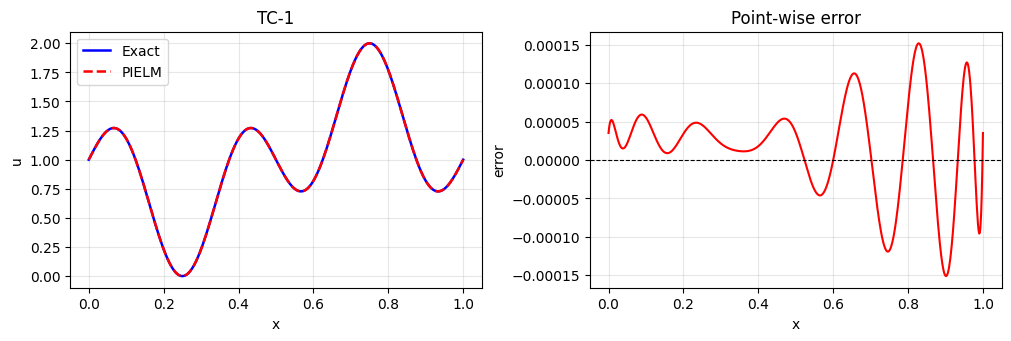

Solve status: ok
Keys in solution: <class 'tuple'>


In [34]:
import json

with open("direct_problem.json", "r", encoding="utf-8") as f:
    problem = json.load(f)

# print(json.dumps(problem, indent=4))
# print(u_exact)
# problem = {
#         "name":"TC-1: 1D steady advection","dim":1,"time":False,
#         "coeffs":{"a0":0,"at":0,"att":0,"bx":1.0,"by":0,"cxx":0,"cxy":0,"cyy":0},
#         "rhs": rhs, "domain":{"x":(0,1)},
#         "bc":{"left":{"type":"dirichlet","value":lambda x,y,t:gL},
#               "right":{"type":"dirichlet","value":lambda x,y,t:gR}},
#         "sampling":{"Nf":1000,"Nb":2,"method":"halton"},
#         "model":{"neurons":800,"activation":"tanh","seed":1,"ridge":1e-10},
#         "weights":{"pde":1.0,"bc":10.0,"ic":5.0},
#         "plot":{"exact":u_exact,"n_plot":600}
#     }
solution = solve_problem(problem)

# Optional: inspect/save results
print("Solve status:", getattr(solution, "status", "ok"))
try:
    import numpy as np
    print("Keys in solution:", list(solution.keys()) if isinstance(solution, dict) else type(solution))
except Exception:
    pass

In [2]:
import numpy as np

u_exact = lambda x,y,t: np.sin(2*np.pi*x) * np.cos(4*np.pi*x) + 1.0
rhs = lambda x,y,t: 2*np.pi*np.cos(2*np.pi*x)*np.cos(4*np.pi*x) - 4*np.pi*np.sin(2*np.pi*x)*np.sin(4*np.pi*x)
xL, xR = 0.0, 1.0; gL = float(u_exact(xL,0,0)); gR = float(u_exact(xR,0,0))
print(gL,gR)

1.0 0.9999999999999998
